In [ ]:
## Identifying the Optimal locations for the ATM coverage area using clustering algorithm

### Overview

Identifying the correct ATM location is a problem of critical importance and optimizing business operations without affecting customer service is very challenging for the banks. In the case of banking services, the location of ATMs must match the service demands (turnaround time for service, accessibility etc) of the customers. Therefore, it is necessary to analyse the geographical data of neighbourhoods so as to reflect the customers' convenience and tolerance for quality of service in a given geographical region.

### Scope

The project scope is to suggest the neighbourhoods for establishing the ATM in the Toronto city based on the foursquare public API and census data. 

### Approach

I propose to utilize the density based clustering algorithm (GDBSCAN) to segment the neighbourhoods based on the location demographics and the preferences for ATM location among customers utilizing the ATM services. 
I will have three datasources: 

1. I will retrieve Foursquare data from their Public API

2. I will use the census block dataset from the data portal of the city of New York City as a grid for the borough of Manhattan.

3. I will use the data from google maps

I would join the data from all the above mentioned sources and clean them for the consumption. I will perform clustering on these data and propose to use the DBSCAN algorithms to cluster the locations. Using the Numerical Heatmap, I would be able to characterize our clusters and rename them accordingly.

Using the clusters and their characteristics,  i would propose the neighbourhoods for establishing the ATM's 

In [1]:
import pandas as pd

In [2]:
data = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
df=data[0]

In [3]:
df.head()


,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [4]:
data1 = pd.read_html("https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&SR=1&S=22&O=A&RPP=9999&PR=0", header = 0, skiprows = [1,2])
df1=data1[0]

In [5]:
df1.head()
df1.drop(columns=['Total private dwellings, 2016', 'Private dwellings occupied by usual residents, 2016'],inplace = True)
df1.rename(columns={'Geographic name':'Postal Code', 'Population,2016':'Population'})
df1.head()                        

,Geographic name,"Population, 2016"
0,A0A,46587
1,A0B,19792
2,A0C,12587
3,A0E,22294
4,A0G,35266


In [6]:
df1.rename(columns={'Geographic name':'Postal Code', 'Population, 2016':'Population'}, inplace=True)
df1.head()  

,Postal Code,Population
0,A0A,46587
1,A0B,19792
2,A0C,12587
3,A0E,22294
4,A0G,35266


In [7]:
df_Borough_NA = df[df ['Borough']== 'Not assigned'].index
df_refined1 = df.drop(df_Borough_NA , inplace=False)
df_refined1.reset_index(drop = True, inplace=True)
df_refined1.head()


,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [8]:
df_refined1.shape

(103, 3)

In [9]:
df1.shape

(1641, 2)

In [10]:
df_merged=pd.merge(df1,df_refined1, on='Postal Code', how='inner')

In [11]:
df_merged.shape

(102, 4)

In [12]:
df_merged.head()

,Postal Code,Population,Borough,Neighbourhood
0,M1B,66108,Scarborough,"Malvern, Rouge"
1,M1C,35626,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,46943,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,29690,Scarborough,Woburn
4,M1H,24383,Scarborough,Cedarbrae


In [13]:

df_merged.loc[(df_merged.Neighbourhood == 'Not assigned'),'Neighbourhood']= df_merged['Borough']

In [14]:
df_merged.head()

,Postal Code,Population,Borough,Neighbourhood
0,M1B,66108,Scarborough,"Malvern, Rouge"
1,M1C,35626,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,46943,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,29690,Scarborough,Woburn
4,M1H,24383,Scarborough,Cedarbrae


In [14]:
df_latlongdata = pd.read_csv("http://cocl.us/Geospatial_data",error_bad_lines=False)
df_latlongdata.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [15]:
df_refined2=pd.merge(df_merged, df_latlongdata, on="Postal Code")
df_refined2.head()

,Postal Code,Population,Borough,Neighbourhood,Latitude,Longitude
0,M1B,66108,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,35626,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,46943,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,29690,Scarborough,Woburn,43.770992,-79.216917
4,M1H,24383,Scarborough,Cedarbrae,43.773136,-79.239476


In [16]:
df_refined2.shape

(102, 6)

In [17]:
df_refined2.dtypes

Postal Code       object
Population         int64
Borough           object
Neighbourhood     object
Latitude         float64
Longitude        float64
dtype: object

In [18]:
CLIENT_ID = '1ORXHKJC5SVAPPLBNAR3VYHFYT1ACJ2O2PBDAUC3LRYZ3KGW' # your Foursquare ID
CLIENT_SECRET = 'QBFIORGPSMYJKHMJMQOBHMKMELTDOEZ4QVWIAED1AEOVMFYR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1ORXHKJC5SVAPPLBNAR3VYHFYT1ACJ2O2PBDAUC3LRYZ3KGW
CLIENT_SECRET:QBFIORGPSMYJKHMJMQOBHMKMELTDOEZ4QVWIAED1AEOVMFYR


In [ ]:
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim


Solving environment: \ 

In [23]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto,Ontario are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto,Ontario are 43.6534817, -79.3839347.


In [25]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done

# All requested packages already installed.



In [26]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_refined2['Latitude'], df_refined2['Longitude'], df_refined2['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [27]:
import json
! pip install requests
import requests # library to handle requests
from pandas.io.json import json_normalize

In [49]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

In [46]:
print(results)

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f37647666f09152f1463184'}, 'response': {}}


In [50]:
categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)


Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


In [51]:
def get_venues_count(ll, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                ll,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']

In [52]:
df_refined2['Coordinates']=df_refined2['Latitude'].astype(str) + "," + df_refined2['Longitude'].astype(str) 

In [53]:
df_refined2.head()

,Postal Code,Population,Borough,Neighbourhood,Latitude,Longitude,Coordinates
0,M1B,66108,Scarborough,"Malvern, Rouge",43.806686,-79.194353,"43.806686299999996,-79.19435340000001"
1,M1C,35626,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,"43.7845351,-79.16049709999999"
2,M1E,46943,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,"43.7635726,-79.1887115"
3,M1G,29690,Scarborough,Woburn,43.770992,-79.216917,"43.7709921,-79.21691740000001"
4,M1H,24383,Scarborough,Cedarbrae,43.773136,-79.239476,"43.773136,-79.23947609999999"


In [54]:
df_refined2.shape
df_refined2.dtypes

Postal Code       object
Population         int64
Borough           object
Neighbourhood     object
Latitude         float64
Longitude        float64
Coordinates       object
dtype: object

In [55]:
#Create new dataframe to store venues data
df_refined3 = df_refined2.copy()
for c in categories_list:
    df_refined3[c[0]] = 0

In [56]:
df_refined3.shape

(102, 17)

In [36]:
df_refined3.drop(df_refined2.index[48])

,Postal Code,Population,Borough,Neighbourhood,Latitude,Longitude,Coordinates
0,M1B,66108,Scarborough,"Malvern, Rouge",43.806686,-79.194353,"43.806686299999996,-79.19435340000001"
1,M1C,35626,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,"43.7845351,-79.16049709999999"
2,M1E,46943,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,"43.7635726,-79.1887115"
3,M1G,29690,Scarborough,Woburn,43.770992,-79.216917,"43.7709921,-79.21691740000001"
4,M1H,24383,Scarborough,Cedarbrae,43.773136,-79.239476,"43.773136,-79.23947609999999"
5,M1J,36699,Scarborough,Scarborough Village,43.744734,-79.239476,"43.7447342,-79.23947609999999"
6,M1K,48434,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,"43.7279292,-79.26202940000002"
7,M1L,35081,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,"43.711111700000004,-79.2845772"
8,M1M,22913,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,"43.716316,-79.23947609999999"
9,M1N,22136,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,"43.692657000000004,-79.2648481"


In [57]:
df_refined3.shape

(102, 17)

In [66]:
for i, row in df_refined3.iterrows():
    print(i)
    for c in categories_list:        
        df_refined3.loc[i, c[0]] = get_venues_count(df_refined3.Coordinates.iloc[i], radius=500, categoryId=c[1])

0


KeyError: 'totalResults'

In [67]:
df_refined3.to_csv('PostalCode_venues.csv')

In [82]:

#Read already stored CSV
PostalCode_venues_df = pd.read_csv('PostalCode_venues.csv', index_col=0)
PostalCode_venues_df.head()

,Postal Code,Population,Borough,Neighbourhood,Latitude,Longitude,Coordinates,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,M1B,66108,Scarborough,"Malvern, Rouge",43.806686,-79.194353,"43.806686299999996,-79.19435340000001",0,0,0,2,0,0,7,0,12,0
1,M1C,35626,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,"43.7845351,-79.16049709999999",1,0,0,0,1,1,3,0,3,1
2,M1E,46943,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,"43.7635726,-79.1887115",0,1,0,5,0,2,4,0,3,4
3,M1G,29690,Scarborough,Woburn,43.770992,-79.216917,"43.7709921,-79.21691740000001",0,0,0,3,0,1,2,0,3,0
4,M1H,24383,Scarborough,Cedarbrae,43.773136,-79.239476,"43.773136,-79.23947609999999",0,1,0,5,1,8,2,0,15,0


In [90]:
PostalCode_venues_df1= PostalCode_venues_df.drop(columns=['Borough','Neighbourhood','Latitude','Longitude','Coordinates','Population'] )
PostalCode_venues_df2= PostalCode_venues_df.drop(columns=['Borough','Neighbourhood','Latitude','Longitude','Coordinates'] )

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

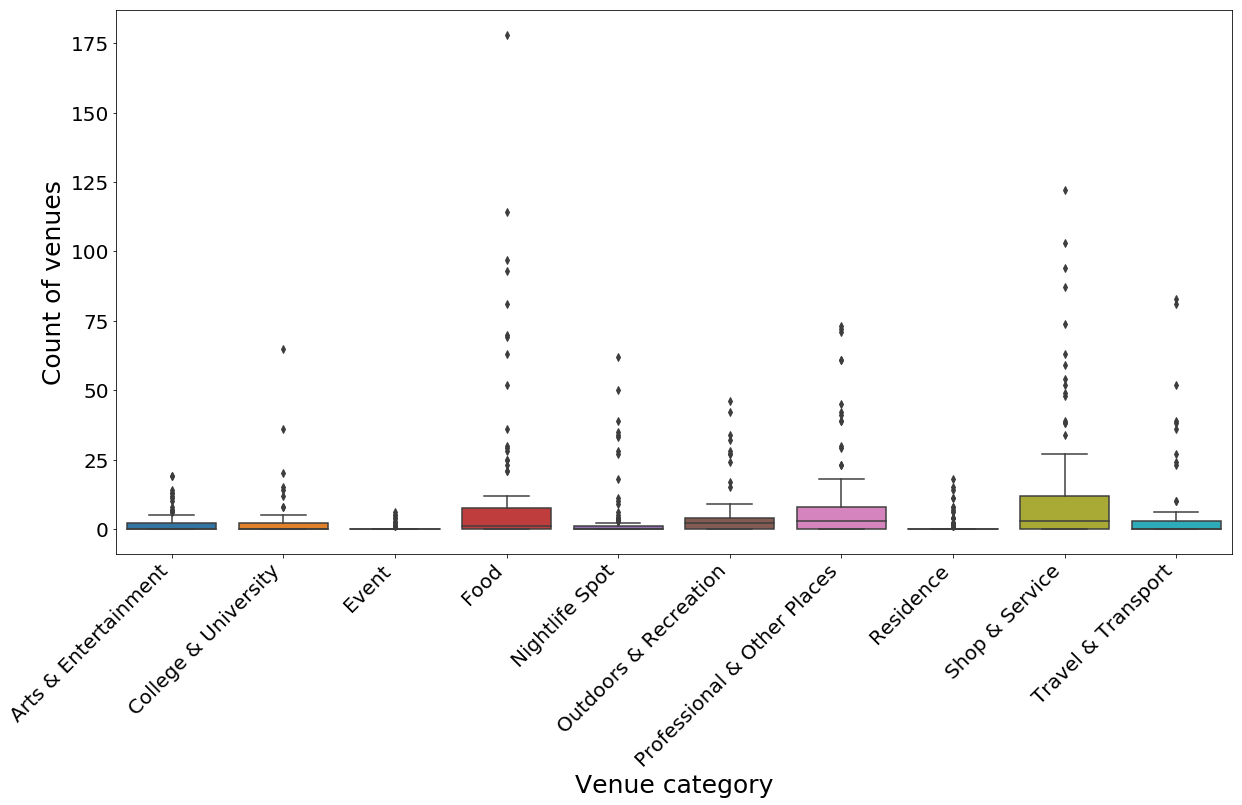

In [85]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = PostalCode_venues_df1)
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

In [86]:
PostalCode_venues_df1.drop('Event', 1, inplace=True)

In [87]:
PostalCode_venues_df1.drop('Residence', 1, inplace=True)

In [88]:
categories_list = list(filter(lambda x: x[0] != 'Event', categories_list))

In [89]:
categories_list = list(filter(lambda x: x[0] != 'Residence', categories_list))

In [91]:
from sklearn.cluster import KMeans

In [97]:
from sklearn.preprocessing import MinMaxScaler

X = PostalCode_venues_df2.values[:,1:]
cluster_dataset = MinMaxScaler().fit_transform(X)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [98]:
print(cluster_dataset)

[[0.87102257 0.         0.         ... 0.         0.09836066 0.        ]
 [0.46939932 0.05263158 0.         ... 0.         0.02459016 0.01204819]
 [0.6185093  0.         0.01538462 ... 0.         0.02459016 0.04819277]
 ...
 [0.44458938 0.         0.         ... 0.         0.         0.        ]
 [0.73730187 0.         0.         ... 0.         0.         0.        ]
 [0.53604227 0.         0.         ... 0.         0.         0.        ]]


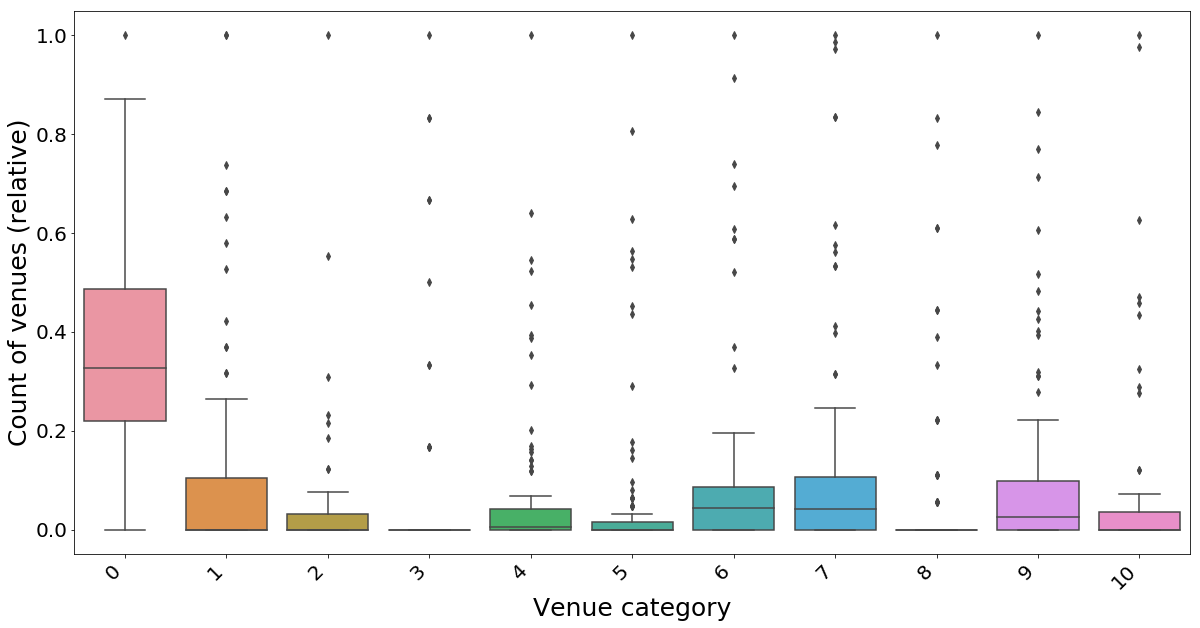

In [100]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster_df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

In [101]:
cluster_df = pd.DataFrame(cluster_dataset)


In [102]:
cluster_df.shape

(102, 11)

In [103]:
cluster_df.columns = ['Population', 'Arts & Entertainment', 'College & University', 'Event', 'Food', 'Nightlife Spot', 'Outdoors & Recreation', 'Professional & Other Places', 'Residence', 'Shop & Service', 'Travel & Transport']

In [104]:
cluster_df.head()

,Population,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.871023,0.000000,0.000000,0.0,0.011236,0.000000,0.000000,0.095890,0.0,0.098361,0.000000
1,0.469399,0.052632,0.000000,0.0,0.000000,0.016129,0.021739,0.041096,0.0,0.024590,0.012048
2,0.618509,0.000000,0.015385,0.0,0.028090,0.000000,0.043478,0.054795,0.0,0.024590,0.048193
3,0.391188,0.000000,0.000000,0.0,0.016854,0.000000,0.021739,0.027397,0.0,0.024590,0.000000
4,0.321264,0.000000,0.015385,0.0,0.028090,0.016129,0.173913,0.027397,0.0,0.122951,0.000000


In [110]:
cluster_df1=cluster_df.drop(columns = ['Event','Residence'])

In [111]:
cluster_df1.head()

,Population,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,0.871023,0.000000,0.000000,0.011236,0.000000,0.000000,0.095890,0.098361,0.000000
1,0.469399,0.052632,0.000000,0.000000,0.016129,0.021739,0.041096,0.024590,0.012048
2,0.618509,0.000000,0.015385,0.028090,0.000000,0.043478,0.054795,0.024590,0.048193
3,0.391188,0.000000,0.000000,0.016854,0.000000,0.021739,0.027397,0.024590,0.000000
4,0.321264,0.000000,0.015385,0.028090,0.016129,0.173913,0.027397,0.122951,0.000000


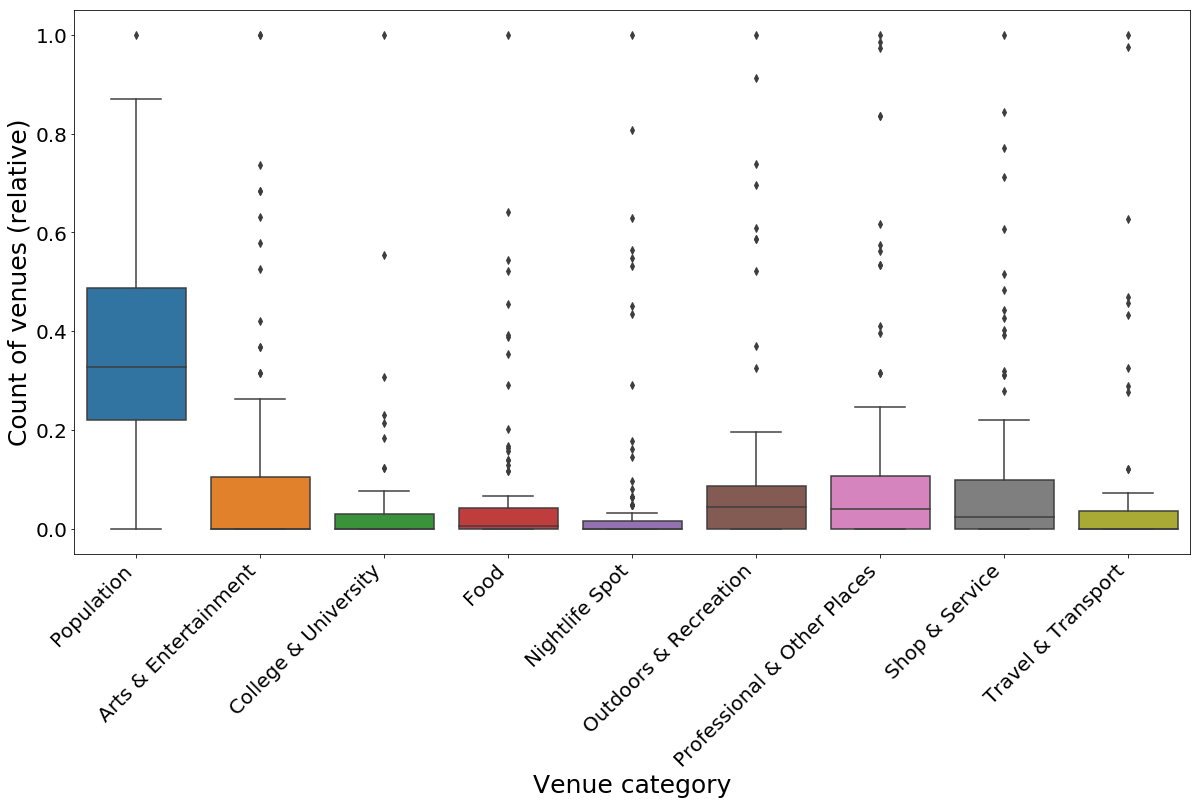

In [113]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster_df1)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()